## 1. 规则方法

最直接的思路，考虑 加购 和 购买 的行为之间的关系

behavior_type = 3与最终的购买行为behavior_type = 4 可能 强关联？

规则：在 T 时间内加购物车的用户最终会选择购买，我们的任务为确定参数 T


## 2. 数据分析

构造新的数据集 D_time = {<user_id, item_id, time_3, time_4>}

In [1]:
item_path = "../data/fresh_comp_offline/tianchi_fresh_comp_train_item.csv"
user_path = "../data/fresh_comp_offline/tianchi_fresh_comp_train_user.csv"

In [2]:
import os
import sys
import timeit
import pandas as pd

start_time = timeit.default_timer()

# 过滤behavior_type = 3 or 4，生成新的数据，保存到../data/act_34.csv

'''
generation of new data sets:
    df_act_34 = {<time, user_id, item_id, behavior_type = 3 or 4>}
here we write .csv file multi-step to handle the large scale data.
'''

batch = 0
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H')
for df in pd.read_csv(open(user_path, 'r'), 
                      chunksize=100000): 
    try:
        df_act_34 = df[df['behavior_type'].isin([3,4])]     
        df_act_34.to_csv('../data/act_34.csv',
                         columns=['time','user_id','item_id','behavior_type'],
                         index=False, header=False,
                         mode = 'a')
        batch += 1
        print('chunk %d done.' %batch) 
        
    except StopIteration:
        print("finish.")
        break 


chunk 1 done.
chunk 2 done.
chunk 3 done.
chunk 4 done.
chunk 5 done.
chunk 6 done.
chunk 7 done.
chunk 8 done.
chunk 9 done.
chunk 10 done.
chunk 11 done.
chunk 12 done.
chunk 13 done.
chunk 14 done.
chunk 15 done.
chunk 16 done.
chunk 17 done.
chunk 18 done.
chunk 19 done.
chunk 20 done.
chunk 21 done.
chunk 22 done.
chunk 23 done.
chunk 24 done.
chunk 25 done.
chunk 26 done.
chunk 27 done.
chunk 28 done.
chunk 29 done.
chunk 30 done.
chunk 31 done.
chunk 32 done.
chunk 33 done.
chunk 34 done.
chunk 35 done.
chunk 36 done.
chunk 37 done.
chunk 38 done.
chunk 39 done.
chunk 40 done.
chunk 41 done.
chunk 42 done.
chunk 43 done.
chunk 44 done.
chunk 45 done.
chunk 46 done.
chunk 47 done.
chunk 48 done.
chunk 49 done.
chunk 50 done.
chunk 51 done.
chunk 52 done.
chunk 53 done.
chunk 54 done.
chunk 55 done.
chunk 56 done.
chunk 57 done.
chunk 58 done.
chunk 59 done.
chunk 60 done.
chunk 61 done.
chunk 62 done.
chunk 63 done.
chunk 64 done.
chunk 65 done.
chunk 66 done.
chunk 67 done.
chun

生成新的数据集

In [3]:
'''
generation of new data sets:
    df_time_34 = {<user_id, item_id, time_3, time_4>}
'''

data_file = open('../data/act_34.csv', 'r')
try:
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H')
    df_act_34 = pd.read_csv(data_file, 
                            parse_dates = [0],
                            date_parser = dateparse,
                            index_col = False)
    df_act_34.columns = ['time','user_id','item_id','behavior_type']
    df_act_34 = df_act_34.drop_duplicates(['user_id','item_id','behavior_type'])  
finally:
    data_file.close()
    
df_time_3 = df_act_34[df_act_34['behavior_type'].isin(['3'])][['user_id','item_id','time']]
df_time_4 = df_act_34[df_act_34['behavior_type'].isin(['4'])][['user_id','item_id','time']]
df_time_3.columns = ['user_id','item_id', 'time3']
df_time_4.columns = ['user_id','item_id', 'time4']
del df_act_34  # to save memory
df_time = pd.merge(df_time_3,df_time_4,on=['user_id','item_id'],how='outer')
df_time_34 = df_time.dropna()  # 删除空

# df_time_3 store the sample contain only behavior_type = 3
# for predict
df_time_3 = df_time[df_time['time4'].isnull()].drop(['time4'], axis = 1)
df_time_3 = df_time_3.dropna()
df_time_3.to_csv('../data/time_3.csv',
                  columns=['user_id','item_id','time3'],
                  index=False)

# save middle data set
df_time_34.to_csv('../data/time_34.csv',
                  columns=['user_id','item_id','time3', 'time4'],
                  index=False)



C:\Users\kang\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


数据可视化

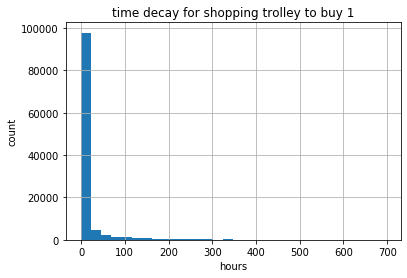

In [4]:
'''
for decay time calculation and visualization 
'''

data_file = open('../data/time_34.csv', 'r')
try:
    df_time_34 = pd.read_csv(data_file, 
                             parse_dates = ['time3', 'time4'],
                             index_col = False)
finally:
    data_file.close()
    
delta_time = df_time_34['time4']-df_time_34['time3']
delta_hour = [] 
for i in range(len(delta_time)):
    d_hour = delta_time[i].days*24+delta_time[i]._h
    if d_hour < 0: continue     # clean invalid result
    else: delta_hour.append(d_hour)

# draw the histogram of delta_hour
import matplotlib.pyplot as plt
f1 = plt.figure(1)
plt.hist(delta_hour, 30)
plt.xlabel('hours')
plt.ylabel('count')
plt.title('time decay for shopping trolley to buy 1')
plt.grid(True)
plt.show()


## 3.做出预估

In [7]:
data_file = open('../data/time_3.csv', 'r')
try:
    df_time_3 = pd.read_csv(data_file, 
                            parse_dates = ['time3'],
                            index_col = ['time3'])
finally:
    data_file.close()
    
ui_pred = df_time_3['2014-12-18']  

# generate from P
data_file = open(item_path, 'r')
try:
    df_item = pd.read_csv(data_file,index_col = False)
finally:
    data_file.close()

ui_pred_in_P = pd.merge(ui_pred,df_item,on = ['item_id'])  

# user_id - item_id to csv file
ui_pred_in_P.to_csv('../data/tianchi_mobile_recommendation_predict.csv',
                    columns=['user_id','item_id'],
                    index=False)

end_time = timeit.default_timer()
print(('The code for file ' + os.path.split(item_path)[1] +
       ' ran for %.2fm' % ((end_time - start_time) / 60.)), file = sys.stderr)

The code for file tianchi_fresh_comp_train_item.csv ran for 8.36m


## 4. 天池结果提交

提交文件 tianchi_mobile_recommendation_predict.csv 到天池比赛的网站

https://tianchi.aliyun.com/competition/entrance/231522/introduction

需要登录



之后可以看到还可以的分数

参考代码：https://github.com/PnYuan/Tianchi-BigData/tree/master/Mobile_Recommendation